In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

In [2]:
ratio = 1500
buy_at = 0.005
fees = 0.0
from_year = "2006"
asset1 = yf.Ticker("BRK-A").history(period='max')[from_year:]
asset2 = yf.Ticker("BRK-B").history(period='max')[from_year:]*ratio

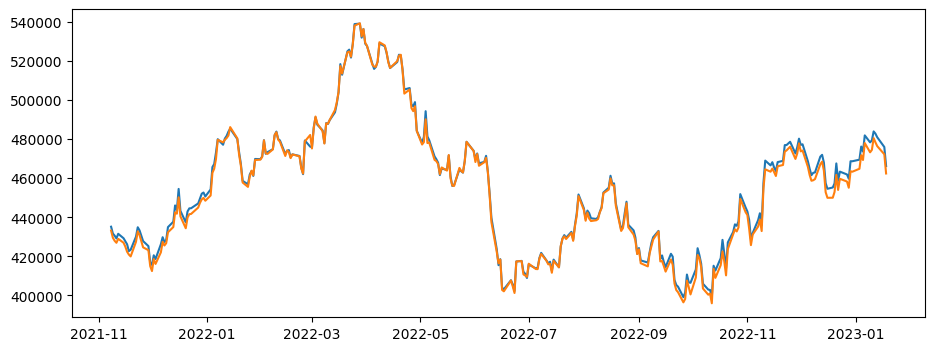

In [3]:
plt.figure(figsize=(11, 4))
plt.plot(asset1.Close[-300:])
plt.plot(asset2.Close[-300:])
plt.show()

In [4]:
delta = (asset2.Close - asset1.Close)/asset2.Close
asset2["delta"] = delta
for pct in [0.005, 0.01]:
    print(f"Percent timesteps difference bigger than {pct*100}%: {(delta.abs()>=pct).sum()/len(delta)*100}%")

Percent timesteps difference bigger than 0.5%: 17.062937062937063%
Percent timesteps difference bigger than 1.0%: 7.80885780885781%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


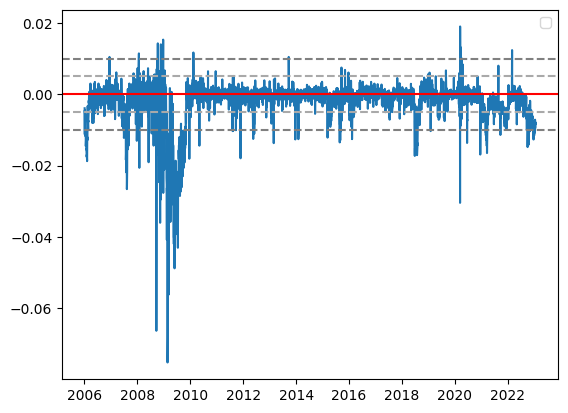

In [5]:
plt.plot(delta)
plt.axhline(0.0, color='red')
plt.axhline(0.01, color='grey', linestyle = '--')
plt.axhline(-0.01, color='grey', linestyle = '--')
plt.axhline(0.005, color='darkgrey', linestyle = '--')
plt.axhline(-0.005, color='darkgrey', linestyle = '--')
plt.legend()
plt.show()

In [6]:
asset2["returns_asset2"] = np.log(1+asset2.Close.pct_change())
asset2["returns_asset1"] = np.log(1+asset1.Close.pct_change())
asset2 = asset2.dropna().replace([np.inf, -np.inf], 0.0)
asset2.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,delta,returns_asset2,returns_asset1
Date,,,,,,,,,,
2006-01-04 00:00:00-05:00,88889.997482,89969.999313,88889.997482,89010.000229,930000000,0.0,0.0,-0.007640,0.000674,0.004358
2006-01-05 00:00:00-05:00,88889.997482,89219.999313,88620.002747,88800.001144,847500000,0.0,0.0,-0.011261,-0.002362,0.001226
2006-01-06 00:00:00-05:00,89040.000916,89399.997711,88830.001831,89100.002289,810000000,0.0,0.0,-0.004489,0.003373,-0.003346
2006-01-09 00:00:00-05:00,88800.001144,89459.999084,88530.000687,89370.002747,915000000,0.0,0.0,-0.005930,0.003026,0.004459
2006-01-10 00:00:00-05:00,89100.002289,89399.997711,88949.998856,89100.002289,637500000,0.0,0.0,-0.007744,-0.003026,-0.001224


In [7]:
arbitrage = False
delta_sign = 0
returns = []
position_row = None
for index, row in asset2.iterrows():
    if not arbitrage and np.abs(row.delta) >= buy_at:
        arbitrage = True
        delta_sign = np.sign(row.delta)
        position_row = asset2.iloc[asset2.index.get_loc(index)+1]
    if arbitrage and delta_sign*row.delta <= 0.0:
        cum_return = -delta_sign*asset2.returns_asset2[position_row.name:row.name].sum()+delta_sign*asset2.returns_asset1[position_row.name:row.name].sum()
        returns.append((position_row.name, row.name, cum_return-fees))
        arbitrage = False
        delta_sign = 0
returns_df = pd.DataFrame(returns, columns=["open_date", "end_date", "return"])
returns_df

,open_date,end_date,return
0,2006-01-05 00:00:00-05:00,2006-03-06 00:00:00-05:00,0.008235
1,2006-04-19 00:00:00-04:00,2006-05-17 00:00:00-04:00,0.008096
2,2006-05-30 00:00:00-04:00,2006-06-12 00:00:00-04:00,0.005753
3,2006-07-06 00:00:00-04:00,2006-07-10 00:00:00-04:00,0.005778
4,2006-10-02 00:00:00-04:00,2006-10-10 00:00:00-04:00,0.006374
...,...,...,...
119,2021-06-18 00:00:00-04:00,2021-08-23 00:00:00-04:00,0.013582
120,2021-09-10 00:00:00-04:00,2022-01-10 00:00:00-05:00,0.008229
121,2022-03-01 00:00:00-05:00,2022-03-01 00:00:00-05:00,0.013760
122,2022-05-04 00:00:00-04:00,2022-05-12 00:00:00-04:00,0.006648


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


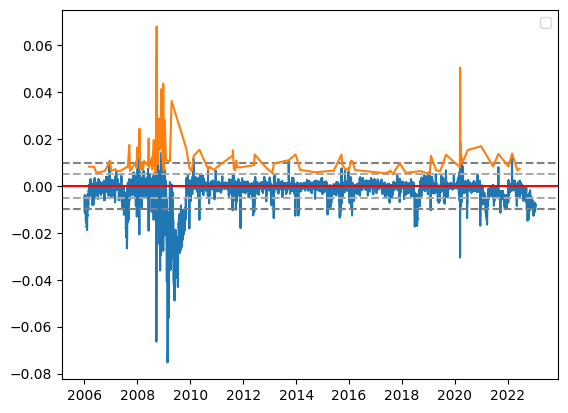

In [8]:
plt.plot(delta)
plt.axhline(0.0, color='red')
plt.axhline(0.01, color='grey', linestyle = '--')
plt.axhline(-0.01, color='grey', linestyle = '--')
plt.axhline(0.005, color='darkgrey', linestyle = '--')
plt.axhline(-0.005, color='darkgrey', linestyle = '--')
plt.plot(returns_df.end_date, np.exp(returns_df['return'])-1)
plt.legend()
plt.show()

In [9]:
print(f"Return: {(np.exp(returns_df['return'])).product()*100}%")

Return: 446.93775774838554%
